In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from faces_128_utils import *
#from faces_test_utils import *
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from matplotlib.pyplot import imshow

%matplotlib inline
np.random.seed(1)

/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/naohi/.py

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [28]:
"""plt.imshow(X_train_orig[0])
print ("y = " + str(np.squeeze(Y_train_orig[:, 0])))"""

im1 = X_train_orig[0]
im2 = Image.new("RGB", (128,128))
for y in range(128):
    for x in range(128):
        r = im1[x][y][0]
        g = im1[x][y][1]
        b = im1[x][y][2]
        im2.putpixel((y,x),(r,g,b))
im2.show()
label = Y_train_orig[0][0]
print(Y_train_orig)
print("This image represents " + str(label) + ".")

[[0 2 1 0 1 0 1 0 0 1 1 2 1 1 1 1 1 2 2 1 0 1 2 1 1 1 0 1 1 1 1 0 2 0 2 1
  0 1 0 2 1 1 1 1 1 1 1 2 1 2 2 0 1 1 1 2 1 1 1 1 1 1 1 1 0 2 0 1 1 1 1 1
  1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1
  1 2 1 1 1 1 2 2 0 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 2 2 2 2 1 2 1 1 1 1 1 1
  2 1 1 2 1 1 2 1 2 0 0 2 1 0 2 1 0 2 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 1
  2 0 2 1 1 1 0 1 1 1 1 2 2 1 1 1 1 1 0 1 1 1 1 1 1 2 0 1 1 1 0 0 1 1 0 2
  1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 2 1 1 1 2 1 0 2 1 1 1 1 1 0 1 2
  1 1 0 1 1 0 1 2 1 1 1 2 2 2 1 2 1 2 1 1 1 1 1 1 2 2 1 1 0 1 2 1 2 1 0 1
  2 1 1 1 1 1 2 1 0 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 0 1 1 2 0 2 1 1 1 1 1 1
  2 1 1 1 1 0 2 1 1 1 1 1 0 0 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1
  1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 2 2 1 2 1 1 2 1 2 1 1 1 1 0 0 0 2 2 2
  1 2 1 1 1 1 0 1 1 1 1 1 2 1 2 2 1 2 2 2 1 1 1 1 1 1 2 1 1 1 0 0 1 1 1 0
  2 1 1 1 2 2 2 2 1 2 1 1 1 0 2 1 0 1 1 1 1 2 0 2 1 1 2 1 0 2 1 0 1 1 1 0
  0 0 2]]
This image represents 0.


In [9]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 3).T
Y_test = convert_to_one_hot(Y_test_orig, 3).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 471
number of test examples = 203
X_train shape: (471, 128, 128, 3)
Y_train shape: (471, 3)
X_test shape: (203, 128, 128, 3)
Y_test shape: (203, 3)


In [10]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])

    return X, Y

In [11]:
def initialize_parameters():
        
    W1 = tf.get_variable('W1',[4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [12]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 3, activation_fn=None)

    return Z3

In [13]:
def compute_cost(Z3, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [29]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.005, num_epochs=150, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    step = 0
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            step += 1

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        """
        print(parameters['W1'].eval())
        print(parameters['W2'].eval())
        """
        # save
        saver = tf.train.Saver()
        saver.save(sess, 'save/onepiece_tfmodel', global_step = step, write_meta_graph = False)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.073715
Cost after epoch 5: 0.984586
Cost after epoch 10: 0.966522
Cost after epoch 15: 0.920170
Cost after epoch 20: 0.865326
Cost after epoch 25: 0.815469
Cost after epoch 30: 0.769394
Cost after epoch 35: 0.740408
Cost after epoch 40: 0.691806
Cost after epoch 45: 0.717139
Cost after epoch 50: 0.540761
Cost after epoch 55: 0.542965
Cost after epoch 60: 0.420274
Cost after epoch 65: 0.374535
Cost after epoch 70: 0.315794
Cost after epoch 75: 0.323979
Cost after epoch 80: 0.251856
Cost after epoch 85: 0.198103
Cost after epoch 90: 0.165787
Cost after epoch 95: 0.155995
Cost after epoch 100: 0.139984
Cost after epoch 105: 0.112611
Cost after epoch 110: 0.084436
Cost after epoch 115: 0.093433
Cost after epoch 120: 0.054826
Cost after epoch 125: 0.041189
Cost after epoch 130: 0.045814
Cost after epoch 135: 0.059252
Cost after epoch 140: 0.028561
Cost after epoch 145: 0.024213


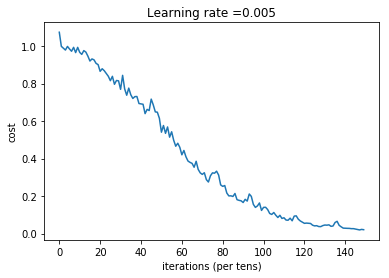

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0
[[[[ 0.41398042 -0.3732289   0.50902146  0.08698988 -0.27155447
     0.1033586   0.04008012  0.4137684 ]
   [ 0.20727822  0.00956736  0.16597123  0.34360558  0.04769094
     0.2560958  -0.29389828  0.16682062]
   [ 0.10263124 -0.44819716  0.5135923   0.658251   -0.38794944
     0.5680509  -0.65119255 -0.37222615]]

  [[ 0.2623747  -0.99366915  0.22317107  0.23255284 -0.15123068
    -0.11505987 -0.09448225 -0.29430225]
   [ 0.43642783 -0.65524817  0.3925139   0.3149932  -0.3638792
     0.00242929 -0.3626171  -0.25522646]
   [ 0.2545965  -1.0088835   0.43601584  0.551217   -0.2613807
     0.5402875  -0.79990774 -1.0314251 ]]

  [[ 0.7259906  -0.7432253  -0.07079029 -0.54793066  0.01771261
    -0.06857102  0.2637257  -0.4712634 ]
   [ 0.37355065 -0.5199727  -0.0208152  -0.40203062 -0.60505533
     0.03866516  0.29742897 -0.5454258 ]
   [ 0.566726   -0.98969793  0.04137279 -0.3593763  -0.5223639
     0.47665

In [30]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
"""
img_path = 'imgs/ruffy_001.jpeg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(model.predict(x))
"""

In [ ]:
#W1 = tf.constant(parameters['W1'], dtype = tf.float32)
#W2 = tf.constant(parameters['W2'], dtype = tf.float32)

In [ ]:
"""def net_input(X, parameters):
    
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 3, activation_fn=None)

    return Z3"""

In [24]:
def predict(X_test, Y_test, parameters):

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        m = X_test.shape[0]
        p = np.zeros((1,m))
    
        Z3 = forward_propagation(X_test, parameters)
        predict_op = tf.argmax(Z3, 1) #Z3が予測値、Yが正解ラベル。argmax()第一軸に沿って、最大となるクラスのラベルを返してくれる。？
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1)) #渡された２つのベクトルが一致しているか否かを見る。True or Falseを返す。

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))#True = 1., False = 0.にcastし、平均をとる。

        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Accuracy:", test_accuracy)
    """
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    return p
    """
    

In [25]:
predict(X_test, Y_test, parameters)

TypeError: Input 'filter' of 'Conv2D' Op has type float32 that does not match type float64 of argument 'input'.

In [ ]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))